  ## COVID19 EDA + CLUSTERING + PROPHET FORECASTING

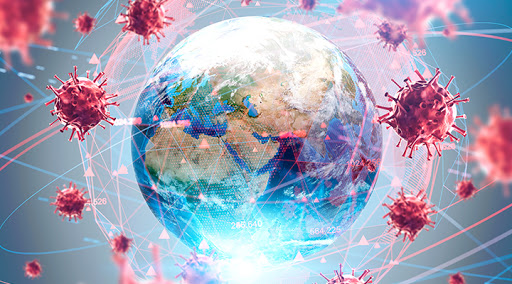


> > ### The coronavirus disease(Covid-19) is an ongoing pandemic caused by severe acute respiratory syndrome coronavirus 2(SARS‑CoV‑2)[1].The outbreak was firstly detected in Wuhan,China,and The World Health Organisation(WHO) declared the outbreak an international health emergency. As of 29 March 2020, more than 677,622 cases of COVID-19 have been reported in 199           countries and territories. As a data scientist, I can help countries and global health institutions to take the necessary steps to fight against the outbreak. In this notebook, my primary objective is to find subgroups among the countries with similar COVID-19 mortality rates, healthcare quality index,and demographic characteristics such as population and average age. In this way, countries in the same groups can help each other and make similar provisions against COVID-19. After identifying subgroups within different countries, I make future forecasting of the number of deaths for countries  from the cluster, which are in urgent need of help and assistance,to guide government officials to cope with COVID-19.  


### Datasets used in the coursework : 
‘Population by Country -2020’ https://www.kaggle.com/tanuprabhu/population-by-country-2020

‘Health Care Index by Country 2020’ https://www.numbeo.com/health-care/rankings_by_country.jsp --- HTML data

‘MERS Outbreak Dataset 2012-2019’  https://www.kaggle.com/imdevskp/mers-outbreak-dataset-20122019

‘SARS 2003 Outbreak Complete Dataset’ https://www.kaggle.com/imdevskp/sars-outbreak-2003-complete-dataset

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry_convert as pc    
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn.cluster
import sklearn.mixture
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from fbprophet import Prophet       
from fbprophet.plot import plot_plotly  
from scipy.stats import boxcox

## Preprocessing Stage

In [ ]:
# Time series data set for confirmed cases between 22.01.2020 and 28.03.2020
confirmed = pd.read_csv('../input/time-series-covid-19-confirmeddeathsrecovered/time_series_covid19_confirmed_global.csv')
# Time series data set for death cases between 22.01.2020 and 28.03.2020
deaths = pd.read_csv('../input/time-series-covid-19-confirmeddeathsrecovered/time_series_covid19_deaths_global.csv')
# Time series data set for recovered cases between 22.01.2020 and 28.03.2020
recovered = pd.read_csv('../input/time-series-covid-19-confirmeddeathsrecovered/time_series_covid19_recovered_global.csv')
# Total number of death, confirmed,recovered and active cases to 28.03.2020 
total = pd.read_csv('../input/covid19-map/csse_covid_19_data/csse_covid_19_daily_reports/03-28-2020.csv')
# Time series data set for death cases between 29.03.2020 and 06.04.2020
future_forecast = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# Sars outbreak cases
sars = pd.read_csv('../input/sars-outbreak-2003-complete-dataset/sars_2003_complete_dataset_clean.csv')
# Mers outbreak cases
mers = pd.read_csv('../input/mers-outbreak-dataset-20122019/country_count_latest.csv')

In [ ]:
# I converted data set into more sutiable way for future forecasting. 
confirmed_ff = confirmed.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],value_vars= confirmed.iloc[:,4:],var_name="Date", value_name="Confirmed")
death_ff = deaths.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],value_vars= deaths.iloc[:,4:], var_name="Date", value_name="Deaths")
recovered_ff = recovered.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],value_vars= recovered.iloc[:,4:],var_name="Date", value_name="Recovered")
future_forecast = future_forecast.melt(id_vars=[ "Lat", "Long","Country/Region"],value_vars= future_forecast.iloc[:,71:78], var_name="Date", value_name="Deaths")
# I merged confirmed, death and recovered cases in one dataframe called full. Full dataframe will be used in future forecasting stage
full = confirmed_ff.merge(death_ff).merge(recovered_ff)
# Change our feature 'Data' type to datetime
full['Date'] = pd.to_datetime(full['Date'])
future_forecast['Date'] = pd.to_datetime(future_forecast['Date'])
# Organise the column names
full = full.rename(columns={"Province/State":"state","Country/Region": "country"})
future_forecast = future_forecast.rename(columns = {"Country/Region": "country"})
# New columns is created. Active cases represent people which still suffer from covid 19
full['Active'] = full['Confirmed'] - full['Deaths'] - full['Recovered']
# Fill null values in state column with blank 
full[['state']] = full[['state']].fillna('')
# Fill null values in Confirmed, Deaths and Recovered columns with zero
full[['Confirmed', 'Deaths', 'Recovered']] = full[['Confirmed', 'Deaths', 'Recovered']].fillna(0)
# Notice there are some instances which have zero latitude and longtitude. These are ships.  
filter1 = full['Lat'] == 0
# MS Zaandam and Diamond Princess are ships. Time series dataframe for those ships
ship = full.where(filter1).dropna()
# Drop the ships from our time series dataframe
full.drop(ship.index, inplace = True)
full.head()

In [ ]:
# Dataframe called total will be used in clustering part
total.drop(['FIPS','Admin2','Last_Update','Combined_Key'],axis = 1,inplace = True)
# Organise the column names
total= total.rename(columns={"Province_State":"state","Country_Region": "country"})
# Fill null values in state column with blank 
total[['state']] = total[['state']].fillna('')
# Fill null values in Confirmed, Deaths and Recovered columns with zero
total[['Confirmed', 'Deaths', 'Recovered','Active']] = total[['Confirmed', 'Deaths', 'Recovered','Active']].fillna(0)
# Notice there are some instances which have zero latitude and longtitude. These are ships.
filter1 = total['Lat'] == 0
# MS Zaandam and Diamond Princess are ships. Total case dataframe for those ships
ship1 = total.where(filter1).dropna()
# Drop the ships from our total case dataframe
total.drop(ship1.index, inplace = True)
total.head()

In [ ]:
# Data types of features in the dataframe
full.dtypes

In [ ]:
# Data types of features in the dataframe
total.dtypes

In [ ]:
# Check the null values in the dataset
sns.heatmap(full.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [ ]:
#Check the null values in the dataset
sns.heatmap(total.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [ ]:
# To give ISO country names to pycountry-convert(for continent names) package, change the name of the some countries
full.loc[full['country'] == "US", "country"] = "USA"
full.loc[full['country'] == 'Korea, South', "country"] = 'South Korea'
full.loc[full['country'] == 'Taiwan*', "country"] = 'Taiwan'
full.loc[full['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
total.loc[total['country'] == "US", "country"] = "USA"
total.loc[total['country'] == 'Korea, South', "country"] = 'South Korea'
total.loc[total['country'] == 'Taiwan*', "country"] = 'Taiwan'
total.loc[total['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'


In [ ]:
# Total country which represents total Confirmed, deaths, recovered and active cases for each country
total_country = total.groupby('country')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
total_country.head()


In [ ]:
# Total numbers for ships
ship_total = ship[ship['Date']==max(ship['Date'])]
ship_total

In [ ]:
# Population data set
population = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
population = population[['Country (or dependency)','Population (2020)', 'Med. Age']]
population.columns= ['country','population','Avrg_age']
population.loc[population['country'] == 'United States', "country"] = "USA"
population.loc[population['country'] == 'Czech Republic (Czechia)', "country"] = 'Czechia'
population.head()

In [ ]:
# Healthcare index data set
health = pd.read_html('https://www.numbeo.com/health-care/rankings_by_country.jsp')
health = health[2]
health = health[['Country', 'Health Care Index']]
health.columns= ['country','healthcare_index']
health.loc[health['country'] == 'United States', "country"] = "USA"
health.loc[health['country'] == 'Czech Republic', "country"] = "Czechia"
health.head()

In [ ]:
# We merge total_country, population and healthcare index data set to find useful clusters in clustering stage
total_country = pd.merge(total_country, population, on='country', how='left',copy = False)
total_country = pd.merge(total_country, health, on='country', how = 'left',copy = False)
# New column is created for clustering stage: Mortality Rate
total_country['Mortality_rate'] = np.round((total_country['Deaths'] / total_country['Confirmed']) *100,2)
total_country.head()

In [ ]:
# However, there are null values in the merged data set. We handle those null values. We replace these with mean values of the dataframe
total_country['Avrg_age'] = total_country['Avrg_age'].fillna(0)
total_country['Avrg_age'] = total_country['Avrg_age'].replace('N.A.', '0')
# Change the datatype of average age column
total_country['Avrg_age'] = total_country['Avrg_age'].astype('int')
total_country['healthcare_index'] = total_country['healthcare_index'].replace(np.nan, total_country['healthcare_index'].mean())
total_country['Avrg_age'] = total_country['Avrg_age'].replace(0, total_country['Avrg_age'].mean())
total_country['Avrg_age'] = total_country['Avrg_age'].replace(np.nan, total_country['Avrg_age'].mean())
total_country['population'] = total_country['population'].replace('N.A.', total_country['population'].mean())
total_country['population'] = total_country['population'].replace(np.nan, total_country['population'].mean())


In [ ]:
# Change the datatype of healthcare index column
total_country['healthcare_index'] = total_country['healthcare_index'].astype('int')
total_country['Avrg_age'] = total_country['Avrg_age'].astype('int')

In [ ]:
# Use pycountry-convert package to assign continent name to each country. But our function didn't assign some countries to continent names
# We assign those countries to 'Others'
# Create dictionary to assing ISO continent name to continents
continents = {
    'EU' : 'Europe',
    'SA': 'South America', 
    'OC': 'Australia',
    'AS': 'Asia',
    'AF': 'Africa',
    'NA': 'North America',
    'Unknown' : 'Others'
}
# All of the countries in the data set
countries = total_country['country'].unique()
def get_continent(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'Unknown'

#Insert continent column to dataframe
total_country.insert(0,"continent", [continents[get_continent(country)] for country in countries])


## Exploratory Data Analysis Stage

In [ ]:
full.head()

In [ ]:
# Worldwide Confirmed cases between 22.01.2020 and 28.03.2020
total_confirm = full.groupby('Date')['Date', 'Confirmed'].sum().reset_index()
fig = px.line(total_confirm, x="Date", y="Confirmed", 
              title="Worldwide Confirmed Cases Over Time")
fig.show()

In [ ]:
# Countries with Confirmed Cases
figure = px.choropleth(total_country, locations="country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="country",  range_color=[1,122000],
                    color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Countries with Confirmed Cases')
figure.show()

In [ ]:
# Size of the circle represents the number of the confirmed cases, whereas colour represents the number of the death cases
fig = px.scatter_geo(total_country, locations="country",locationmode='country names', color="Deaths",
                     hover_name="country", size="Confirmed",hover_data = ['country','Deaths','Mortality_rate','Confirmed'],
                     projection="natural earth",title='Countries with Confirmed and Death Cases')
fig.show()

In [ ]:
# Size of the circle represents the number of the confirmed cases, whereas colour represents the number of the recovered cases
fig = px.scatter_geo(total_country, locations="country",locationmode='country names', color="Recovered",
                     hover_name="country", size="Confirmed",hover_data = ['country','Recovered', 'Confirmed'],
                     projection="natural earth",title='Countries with Confirmed and Recovered Cases')
fig.show()

In [ ]:
# Countries with active cases
fig = px.treemap(total_country, path=['continent','country'], values='Active',
                 height=600,title='Number of Active Cases',color_discrete_sequence = px.colors.qualitative.Dark2)
fig.data[0].textinfo = 'label+text+value'
fig.show()

In [ ]:
# Continents with Confirmed Cases
total_continent= total_country.groupby('continent')['continent', 'Confirmed'].sum().reset_index()
fig = px.bar(total_continent.sort_values('Confirmed', ascending=False)[::-1], x='Confirmed', y='continent',color_discrete_sequence=['#84DCC6'],
             title='Continents with Confirmed Cases', text='Confirmed', height=500, orientation='h')
fig.show()

In [ ]:
#Confirmed cases in Europe
europe = total_country[total_country['continent'] == 'Europe']
fig = px.choropleth(europe, locations="country", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="country", 
                     color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Confirmed cases in Europe', scope='europe', height=800)
fig.show()

In [ ]:
# Continents with Death Cases
total_continent1= total_country.groupby('continent')['continent', 'Deaths'].sum().reset_index()
fig = px.bar(total_continent1.sort_values('Deaths', ascending=False)[::-1], x='Deaths', y='continent',color_discrete_sequence=['#D63230'],
             title='Continents with Deaths Cases', text='Deaths', height=500, orientation='h')
fig.show()

In [ ]:
# Death Cases in Europe
fig = px.choropleth(europe, locations="country", 
                    locationmode='country names', color="Deaths", 
                    hover_name="country", 
                     color_continuous_scale= px.colors.sequential.Viridis, 
                    title='Death cases in Europe', scope='europe', height=800)
fig.show()

In [ ]:
# Create dataframe which consists of three important outbreaks
outbreaks = {'Outbreaks' : ['COVID19', 'SARS', 'MERS'],
            'Confirmed' : [total_country['Confirmed'].sum(),sars[sars['Date'] == '2003-07-11']['Cumulative number of case(s)'].sum(),mers['Confirmed'].sum() ]}
df = pd.DataFrame(outbreaks, columns = ['Outbreaks', 'Confirmed'])
fig = px.bar(df.sort_values('Confirmed', ascending=False)[::-1], x='Confirmed', y='Outbreaks',color_discrete_sequence=['#D63230'],
             title='Three Important Outbreak with Confirmed Cases', text='Confirmed', height=500, orientation='h')
fig.show()

In [ ]:
# Top 50 Countries with confirmed, deaths and mortality rates 
total_country.sort_values('Confirmed', ascending=False)[['country','Confirmed', 'Deaths', 'Mortality_rate']][:50].style.background_gradient(cmap='Reds')

## Proposed Method 

### Clustering + Future Forecasting

In [ ]:
# In clustering part we will use first 50 countries with highest confirmed case numbers. 
total_50 = total_country.sort_values(by = 'Confirmed', ascending = False).head(50)

In [ ]:
# Feature Correlation map
sns.heatmap(total_50.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Feature selection respect to correlation map
data = total_50[['Mortality_rate','Avrg_age','population','healthcare_index']]

In [ ]:
# Describe the dataframe to see variation of the data. Variation in population is high. We must normalize it. 
data.describe()

### Clustering

### Kmeans

In [ ]:
# Standardisation the data because groups are defined based on the distance between points
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
pd.DataFrame(data_scaled).describe()

In [ ]:
# calculate the sum of squares of the distances of each data points which represents countries
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    y_means = kmeans.fit(data_scaled)
    wcss.append(y_means.inertia_)
# Plot WCSS to find the number of clusters
plt.plot(range(1,11), wcss)
plt.xlabel("No. of clusters")
plt.ylabel(" Within Cluster Sum of Squares")
plt.show()

In [ ]:
# Decide the number of clusters. The coefficient varies between -1 and 1. The best value is 1
silhoutte=[]
for i in range(3,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    y_means = kmeans.fit(data_scaled)
    data_cluster = y_means.predict(data_scaled)
    silhoutte.append(sklearn.metrics.silhouette_score(data_scaled,data_cluster))
#Plot silhoutte score to find the number of clusters
plt.plot(range(3,11), silhoutte)
plt.xlabel("No. of clusters")
plt.ylabel("Silhoutte Score for each cluster")
plt.show()

In [ ]:
# Initialise the model with the number of clusters
k_meansmodel = sklearn.cluster.KMeans(6,init='k-means++')
# Fit the model
k_meansmodel.fit(data_scaled)
# Predict the clusters
data_cluster = k_meansmodel.predict(data_scaled)

In [ ]:
# Visualisation of the clusters is not easy becasue our data have more than 2 dimensions
plt.figure(figsize=(8, 4))
# Mortality rate vs average age of the countries
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c= data_cluster, cmap = 'rainbow')
plt.xlabel('Mortality rate')
plt.ylabel('Average Age')
plt.title('Visualisation of risk groups based on mortality rate and average age with K-Means clustering')
plt.show()

In [ ]:
# We grouped countries into 6 groups respecto K-means clustering
risk_group= pd.DataFrame()
risk_group["country"]=total_50["country"]
risk_group["risk_group"]=data_cluster
for group in range(0,6):
    countries=risk_group.loc[risk_group['risk_group']==group]
    country_list= list(countries['country'])
    print("Group", group, ":", country_list)

In [ ]:
risk_group['Mortality_rate'] = data_scaled[:,0]
risk_group['Avrg_age'] = data_scaled[:,1]
risk_group['population'] = data_scaled[:,2]
risk_group['healthcare_index'] = data_scaled[:,3]



In [ ]:
risk_group["risk_group"] = risk_group["risk_group"].astype(str)
fig = px.scatter(risk_group, x="Mortality_rate", y="Avrg_age", color="risk_group", hover_name = 'country',category_orders={"risk_group": ["0", "1", "2", "3", "4","5"]},width = 600, height = 400 )
fig.update_layout(
    title=" Visualisation of risk groups based on mortality rate and average age with K-Means clustering",
    xaxis_title="Mortality rate",
    yaxis_title="Average Age",
    font=dict(
        size=8,
        color="#7f7f7f"))
fig.show()

### Gaussian Mixture Model

In [ ]:
# Standardize the data because population may dominate the other variables otherwise
scaler = StandardScaler()
data_scaled2 = scaler.fit_transform(data)
pd.DataFrame(data_scaled2).describe()

In [ ]:
# Decide the number of clusters. The coefficient varies between -1 and 1. The best value is 1
silhoutte2=[]
for i in range(3,11):
    gmm_model = sklearn.mixture.GaussianMixture(i)
    gmm_model.fit(data_scaled2)
    gmm_model_cluster = gmm_model.predict(data_scaled2)
    silhoutte2.append(sklearn.metrics.silhouette_score(data_scaled2,gmm_model_cluster))
# Plot silhoutte score to find the number of clusters
plt.plot(range(3,11), silhoutte2)
plt.xlabel("No. of clusters")
plt.ylabel("Silhoutte score for each cluster")
plt.show()

In [ ]:
# Initalise the model with number of components
gmm_model = sklearn.mixture.GaussianMixture(7)
# fit our data to the model
gmm_model.fit(data_scaled2)
# predict data clusters 
gmm_model_cluster = gmm_model.predict(data_scaled2)
# Visualisation of the clusters is not easy becasue our data have more than 2 dimensions
# Mortality rate vs average age of the countries
plt.figure(figsize=(10, 8))
plt.scatter(data_scaled2[:, 0], data_scaled2[:, 1], c= gmm_model_cluster,cmap = 'rainbow')
plt.xlabel('Mortality rate')
plt.ylabel('Average Age')
plt.title('Visualisation of risk groups based on mortality rate and average age with Gaussian Mixture Clustering')


In [ ]:
# We grouped countries into 6 groups respecto Gaussian mixture clustering
risk_group2= pd.DataFrame()
risk_group2["country"]=total_50["country"]
risk_group2["risk_group"]=gmm_model_cluster
for group in range(0,7):
    countries=risk_group2.loc[risk_group2['risk_group']==group]
    country_list1 = list(countries['country'])
    print("Group", group, ":", country_list1)

In [ ]:
# See the same pattern for confirmed cases in K-means group 3. Also,we will focus on group 3 in future forecasting stage
italy = full[full['country'] == 'Italy']
grouped_italy = italy.groupby('Date')['Date', 'Confirmed', 'Deaths','country'].sum().reset_index()
spain = full[full['country'] == 'Spain']
grouped_spain = spain.groupby('Date')['Date', 'Confirmed', 'Deaths'].sum().reset_index()
france = full[full['country'] == 'France']
grouped_france = france.groupby('Date')['Date', 'Confirmed', 'Deaths','country'].sum().reset_index()
uk = full[full['country'] == 'United Kingdom']
grouped_uk = uk.groupby('Date')['Date', 'Confirmed', 'Deaths'].sum().reset_index()
netherlands = full[full['country'] == 'Netherlands']
grouped_netherlands = netherlands.groupby('Date')['Date', 'Confirmed', 'Deaths'].sum().reset_index()
fig = px.line(grouped_italy, x = 'Date', y= 'Deaths', title="Italy Death Cases Over Time")
fig.show()
fig = px.line(grouped_spain, x = 'Date', y= 'Deaths', title="Spain Death Cases Over Time")
fig.show()
fig = px.line(grouped_france, x = 'Date', y= 'Deaths', title="France Death Cases Over Time")
fig.show()
fig = px.line(grouped_uk, x = 'Date', y= 'Deaths', title="United Kingdom Death Cases Over Time")
fig.show()
fig = px.line(grouped_netherlands, x = 'Date', y= 'Deaths', title="Netherlands Death Cases Over Time")
fig.show()

### Future Forecasting - Prophet Method

In [ ]:
# In this stage we will focus on K-means group 3. Prepare the data for Prophet method. We use time series dataframe
# Between 22.01.2020 - 28.03.2020
italy = full[full['country'] == 'Italy']
spain = full[full['country'] == 'Spain']
france = full[full['country'] == 'France']
uk = full[full['country'] == 'United Kingdom']
netherlands = full[full['country'] == 'Netherlands']
# Set Date to index and sum all the deaths respect to date
full_prophet_italy = italy.groupby('Date').sum()['Deaths'].reset_index()
full_prophet_spain = spain.groupby('Date').sum()['Deaths'].reset_index()
full_prophet_france = france.groupby('Date').sum()['Deaths'].reset_index()
full_prophet_uk = uk.groupby('Date').sum()['Deaths'].reset_index()
full_prophet_net = netherlands.groupby('Date').sum()['Deaths'].reset_index()

In [ ]:
# Prepare the data to evaluate prophet method. Future forecast dataframe contains death cases between 29.03.2020 and 06.04.2020
future_italy = future_forecast[future_forecast['country'] == 'Italy']
future_spain = future_forecast[future_forecast['country'] == 'Spain']
future_france = future_forecast[future_forecast['country'] == 'France']
future_uk = future_forecast[future_forecast['country'] == 'United Kingdom']
future_net = future_forecast[future_forecast['country'] == 'Netherlands']
# Set Date to index and sum all the deaths respect to date
future_italy = future_italy.groupby('Date').sum()['Deaths'].reset_index()
future_spain = future_spain.groupby('Date').sum()['Deaths'].reset_index()
future_france = future_france.groupby('Date').sum()['Deaths'].reset_index()
future_uk = future_uk.groupby('Date').sum()['Deaths'].reset_index()
future_net = future_net.groupby('Date').sum()['Deaths'].reset_index()

In [ ]:
# Prophet only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column
full_prophet_italy.columns = ['ds','y']
full_prophet_spain.columns = ['ds','y']
full_prophet_france.columns = ['ds','y']
full_prophet_uk.columns = ['ds','y']
full_prophet_net.columns = ['ds','y']

## Italy

### Prophet Method

In [ ]:
# Initialize prophet method for Italy
p = Prophet(interval_width=0.95,yearly_seasonality= True,daily_seasonality=True)
# Fit the data
p.fit(full_prophet_italy)
# Predict death cases for following 7 days
future = p.make_future_dataframe(periods=7)
forecast = p.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Evaluate model with compare real results
error_italy = mean_squared_error(future_italy['Deaths'].array,forecast['yhat'].tail(7).array )
print('Mean squarred error of Prophet Method for Italy is :', error_italy)

In [ ]:
plt.scatter(future_italy['Deaths'].array,forecast['yhat'].tail(7).array)
plt.xlabel('Acutal number of death cases for Italy')
plt.ylabel('Predicted number of death cases for Italy')
plt.title('Actual number vs Predicted Number for Italy')

In [ ]:
confirmed_forecast_plot_italy = p.plot(forecast, xlabel = 'Date', ylabel = 'Deaths in Italy')

## Spain

## Prophet method

In [ ]:
# # Initialize prophet method for Spain
p1 = Prophet(interval_width=0.95,yearly_seasonality= True,daily_seasonality=True)
# Fit the data
p1.fit(full_prophet_spain)
# Predict death cases for following 7 days
future1 = p1.make_future_dataframe(periods=7)
forecast1 = p1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Evaluate model with compare real results
error_spain = mean_squared_error(future_spain['Deaths'].array,forecast1['yhat'].tail(7).array )
print('Mean squarred error of Prophet Method for Spain is :', error_spain)

In [ ]:
plt.scatter(future_spain['Deaths'].array,forecast1['yhat'].tail(7).array)
plt.xlabel('Acutal number of death cases for Spain')
plt.ylabel('Predicted number of death cases for Spain')
plt.title('Actual number vs Predicted Number for Spain')

In [ ]:
confirmed_forecast_plot_spain = p1.plot(forecast1, xlabel = 'Date', ylabel = 'Deaths in Spain')

### France

### Prophet Method

In [ ]:
# # Initialize prophet method for France
p2 = Prophet(interval_width=0.95,yearly_seasonality= True,daily_seasonality=True)
# Fit the data
p2.fit(full_prophet_france)
# Predict death cases for following 7 days
future2 = p2.make_future_dataframe(periods=7)
forecast2 = p2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Evaluate model with compare real results
error_france = mean_squared_error(future_france['Deaths'].array,forecast2['yhat'].tail(7).array )
print('Mean squarred error of Prophet Method for France is :', error_france)

In [ ]:
plt.scatter(future_france['Deaths'].array,forecast2['yhat'].tail(7).array)
plt.xlabel('Acutal number of death cases for France')
plt.ylabel('Predicted number of death cases for France')
plt.title('Actual number vs Predicted Number for France')

In [ ]:
confirmed_forecast_plot_france = p2.plot(forecast2, xlabel = 'Date', ylabel = 'Deaths in France')

### United Kingdom

### Prophet Method

In [ ]:
# # Initialize prophet method for United Kingdom
p3 = Prophet(interval_width=0.95,yearly_seasonality= True,daily_seasonality=True)
# Fit the data
p3.fit(full_prophet_uk)
# Predict death cases for following 7 days
future3 = p3.make_future_dataframe(periods=7)
forecast3 = p3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Evaluate model with compare real results
error_uk = mean_squared_error(future_uk['Deaths'].array,forecast3['yhat'].tail(7).array )
print('Mean squarred error of Prophet Method for United Kingdom is :', error_uk)

In [ ]:
plt.scatter(future_uk['Deaths'].array,forecast3['yhat'].tail(7).array)
plt.xlabel('Acutal number of death cases for United Kingdom')
plt.ylabel('Predicted number of death cases for United Kingdom')
plt.title('Actual number vs Predicted Number for United Kingdom')

In [ ]:
confirmed_forecast_plot_france = p3.plot(forecast3, xlabel = 'Date', ylabel = 'Deaths in United Kingdom')

### Netherlands

### Prophet Method

In [ ]:
# Initialize prophet method for Netherlands
p4 = Prophet(interval_width=0.95,yearly_seasonality= True,daily_seasonality=True)
# Fit the data
p4.fit(full_prophet_net)
# Predict death cases for following 7 days
future4 = p4.make_future_dataframe(periods=7)
forecast4 = p4.predict(future4)
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [ ]:
# Evaluate model with compare real results
error_net = mean_squared_error(future_net['Deaths'].array,forecast4['yhat'].tail(7).array )
print('Mean squarred error of Prophet Method for Netherlands is :', error_net)

In [ ]:
plt.scatter(future_net['Deaths'].array,forecast4['yhat'].tail(7).array)
plt.xlabel('Acutal number of death cases for Netherlands')
plt.ylabel('Predicted number of death cases for Netherlands')
plt.title('Actual number vs Predicted Number for Netherlands')

In [ ]:
confirmed_forecast_plot_france = p4.plot(forecast4, xlabel = 'Date', ylabel = 'Deaths in Netherlands')